# Imports
Importing necessary packages and modules

In [1]:
%matplotlib inline

from torchwrap.data import CIFAR10
from torchwrap.model import ResidualModel
from torchwrap.model.utils.loss import cross_entropy_loss
from torchwrap.model.utils.optimizers import sgd
from torchwrap.engine import LRFinder
from torchwrap.engine.ops.lr_scheduler import OneCyclePolicy
from torchwrap.utils import initialize_cuda, plot_metric
from torchwrap.utils.clr import CyclicLR

## Set Seed and Get GPU Availability

In [2]:
# Initialize CUDA and set random seed
cuda, device = initialize_cuda(1)

GPU Available? True


## Download Dataset

Importing the CIFAR-10 class to download dataset and create data loader

In [3]:
dataset = CIFAR10(
    train_batch_size=512,
    val_batch_size=512,
    cuda=cuda,
    num_workers=16,
    padding=(40, 40),
    crop=(32, 32),
    horizontal_flip_prob=0.2,
    cutout_prob=0.1,
    cutout_dim=(8, 8),
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Training and Validation Dataloaders
This is the final step in data preparation. It sets the dataloader arguments and then creates the dataloader

In [4]:
# Create train data loader
train_loader = dataset.loader(train=True)

# Create val data loader
val_loader = dataset.loader(train=False)

# Model Architecture and Summary

In [5]:
model = ResidualModel().to(device)  # Create model
model.summary(dataset.image_size)  # Display model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
    ResidualBlock-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

# LR Range Test

In [6]:
start_lr = 1e-6
end_lr = 0.02
num_iterations = 10 * len(train_loader)  # 10 epochs

# Create optimizer and loss function
optimizer = sgd(model, learning_rate=start_lr, momentum=0.9, l2_factor=0.01)
criterion = cross_entropy_loss()

# LR Range Test
lr_finder = LRFinder(model, optimizer, criterion, metric='accuracy', device=device)
lr_finder.range_test(
    train_loader, num_iterations, mode='iteration',
    end_lr=end_lr, step_mode='linear', diverge_th=0
)

Iterations
980/980 [========] - 101s 103ms/step - lr: 0.0101 - Accuracy: 56.6245
Learning rate search finished.


Learning Rate: 0.02002040714285714
Accuracy: 0.715928


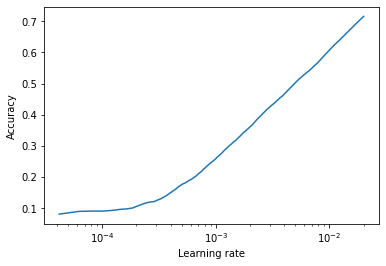

In [7]:
# Get best initial learning rate
initial_lr = lr_finder.best_lr

print('Learning Rate:', initial_lr)
print('Accuracy:', lr_finder.best_metric)

# Plot learning rate vs accuracy
lr_finder.plot()

# Reset graph
lr_finder.reset()

# One Cycle Policy Schedule

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


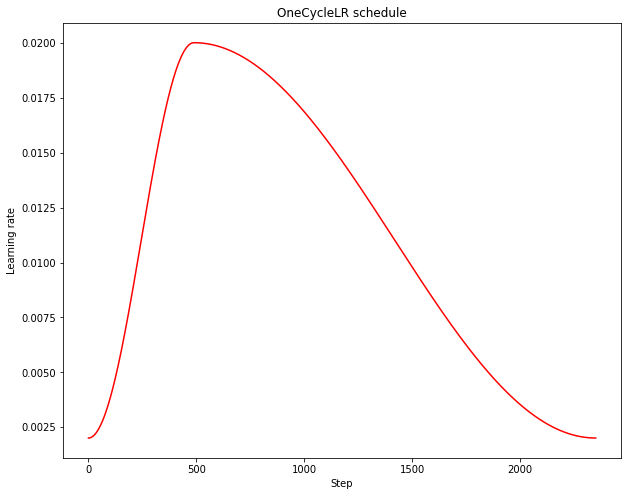

<Figure size 432x288 with 0 Axes>

In [8]:
epochs = 24

# Define one cycle policy
one_cycle_policy = OneCyclePolicy(optimizer=optimizer, max_lr=initial_lr,
                                  epochs=epochs, steps_per_epoch=len(train_loader),
                                  pct_start=5/epochs, div_factor=10, final_div_factor=1)

one_cycle_policy.plot_policy()

# Model Training and Validation

In [9]:
one_cycle_policy = OneCyclePolicy(optimizer=optimizer, max_lr=initial_lr,
                                  epochs=epochs, steps_per_epoch=len(train_loader),
                                  pct_start=5/epochs, div_factor=10, final_div_factor=1)

# Train model
model.fit(
    train_loader, optimizer, criterion, device=device, epochs=epochs,
    val_loader=val_loader, callbacks=[one_cycle_policy]
)

Epoch 1:
98/98 [========] - 10s 100ms/step - loss: 1.8569 - accuracy: 30.7503
Validation set: Average loss: 0.0025, Accuracy: 55.45%

Epoch 2:
98/98 [========] - 10s 100ms/step - loss: 1.1663 - accuracy: 46.4956
Validation set: Average loss: 0.0023, Accuracy: 61.68%

Epoch 3:
98/98 [========] - 10s 100ms/step - loss: 0.9884 - accuracy: 53.1849
Validation set: Average loss: 0.0016, Accuracy: 72.23%

Epoch 4:
98/98 [========] - 10s 100ms/step - loss: 0.7355 - accuracy: 58.4403
Validation set: Average loss: 0.0022, Accuracy: 66.26%

Epoch 5:
98/98 [========] - 10s 101ms/step - loss: 0.6410 - accuracy: 62.4955
Validation set: Average loss: 0.0012, Accuracy: 80.36%

Epoch 6:
98/98 [========] - 10s 103ms/step - loss: 0.4930 - accuracy: 65.7946
Validation set: Average loss: 0.0012, Accuracy: 80.39%

Epoch 7:
98/98 [========] - 10s 101ms/step - loss: 0.4274 - accuracy: 68.6581
Validation set: Average loss: 0.0010, Accuracy: 82.77%

Epoch 8:
98/98 [========] - 10s 102ms/step - loss: 0.3863 - ac

# Cyclic LR Triangular Schedule

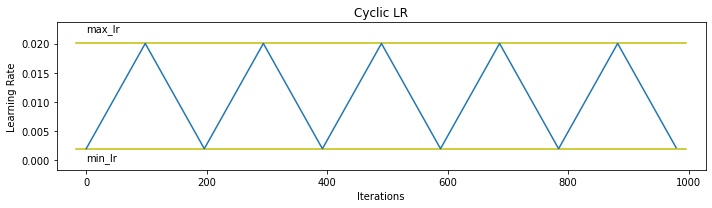

In [10]:
triangular_lr = CyclicLR(initial_lr, initial_lr / 10, len(train_loader), len(train_loader) * 10)
triangular_lr.cyclic_lr(plot=True)

## Plotting Accuracy

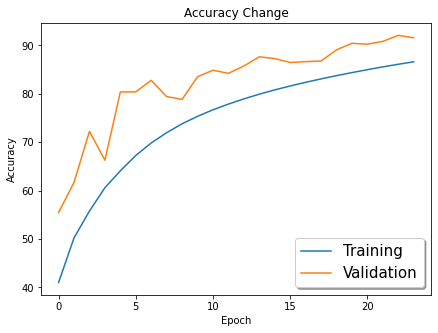

In [11]:
plot_metric({
    'Training': model.learner.train_accuracies,
    'Validation': model.learner.val_accuracies
}, 'Accuracy')